In [ ]:
!pip install pennylane --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pennylane as qml
import pennylane.numpy as np
import autograd.numpy as anp
import pandas as pd
import matplotlib.pyplot as plt
import os
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10

from sklearn.decomposition import PCA

from google.colab import drive
drive.mount('/content/drive')

import time
import datetime

import json

SEED = 42
def seed_everything(seed: int = 42):
  random.seed(seed)
  np.random.seed(seed)
  os.environ["PYTHONHASHSEED"] = str(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)  # type: ignore
  torch.backends.cudnn.deterministic = True  # type: ignore
  torch.backends.cudnn.benchmark = True  # type: ignore

seed_everything(seed = SEED)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class TrainTestLoader(object):
  def __init__(self, dataset="CIFAR10", feature_reduction='pca', size=16):
    self.dataset = dataset

    self.training_data=None
    self.test_data=None

    self.train_X = None
    self.train_y = None
    self.test_X = None
    self.test_y = None

    if self.dataset == "CIFAR10":
      download_root = "./CIFAR10_DATASET"
      CIFAR10_transform = transforms.Compose([
                    transforms.ToTensor()
                  ])
      self.training_data = CIFAR10(download_root,
                        train=True,
                        download=True,
                        transform=CIFAR10_transform)

      self.test_data = CIFAR10(download_root,
                        train=False,
                        download=True,
                        transform=CIFAR10_transform)

      train_X = torch.Tensor(self.training_data.data) / 255.0
      train_y = torch.Tensor(self.training_data.targets)

      test_X = torch.Tensor(self.test_data.data) / 255.0
      test_y = torch.Tensor(self.test_data.targets)

      # airplane(index=0), dog(index=5)에 해당하는 데이터만 추출
      self.train_X = train_X[(train_y==0) | (train_y==5)]
      self.train_y = train_y[(train_y==0) | (train_y==5)]
      self.test_X = test_X[(test_y==0) | (test_y==5)][:1000]
      self.test_y = test_y[(test_y==0) | (test_y==5)][:1000]
      
      # airplane은 0으로 dog는 1로 index변환
      self.train_y = torch.where(self.train_y==0, 0, 1).numpy()
      self.test_y = torch.where(self.test_y==0, 0, 1).numpy()
    

    if self.dataset == "CIFAR10" and feature_reduction=='resize':
      size = int(np.sqrt(size))
      t = transforms.Resize(size=(size, size))
      train_X_p = self.train_X.permute(0,3,1,2)
      test_X_p = self.test_X.permute(0,3,1,2)
      train_X = t(train_X_p).permute(0,2,3,1)
      test_X = t(test_X_p).permute(0,2,3,1)

      self.train_X = train_X.reshape((train_X.shape[0],
                                    train_X.shape[1]*train_X.shape[2],
                                      train_X.shape[3])).numpy()
      self.test_X = test_X.reshape((test_X.shape[0],
                                    test_X.shape[1]*test_X.shape[2],
                                      test_X.shape[3])).numpy()
    
    elif self.dataset == "CIFAR10" and feature_reduction=='pca':
      train_shape = self.train_X.shape
      test_shape = self.test_X.shape
      train_X = self.train_X.reshape((train_shape[0],
                                      train_shape[1]*train_shape[2],
                                      train_shape[3]))
      test_X = self.test_X.reshape((test_shape[0],
                                      test_shape[1]*test_shape[2],
                                      test_shape[3]))
      train_X_pca =\
                np.zeros((train_shape[0], size, train_shape[3]))
      test_X_pca =\
                np.zeros((test_shape[0], size, test_shape[3]))
      #channel별로 pca적용
      for channel in range(train_shape[-1]):
        pca = PCA(n_components = size)
        train_X_pca[:,:,channel] = pca.fit_transform(train_X[:,:,channel])
        test_X_pca[:,:,channel] = pca.transform(test_X[:,:,channel])
        if size <= 30:
          ### Rescale for angle embedding
          train_X_scale = train_X_pca[:,:,channel]
          test_X_scale = test_X_pca[:,:,channel]
          train_X_pca[:,:,channel] = (train_X_scale - train_X_scale.min())\
                         * (np.pi / (train_X_scale.max() - train_X_scale.min()))
          test_X_pca[:,:,channel] = (test_X_scale - test_X_scale.min())\
                         * (np.pi / (test_X_scale.max() - test_X_scale.min()))

      self.train_X = train_X_pca
      self.test_X = train_X_pca


  def return_dataset(self):
      return self.train_X, self.test_X, self.train_y, self.test_y
      


In [ ]:
class EmbeddingMethod():
  def __init__(self, n_qubits = 24, embedding_type = "Angle-compact"):
    self.n_qubits = n_qubits
    self.embedding_type = embedding_type
  
  def embed_data (self, inputs):
    if self.embedding_type == "Amplitude": # need (2^n_qubits) features
      qml.AmplitudeEmbedding(inputs, wires=range(self.n_qubits),
                           pad_with=0, normalize=True)
      
    # elif self.embedding_type == 'Angle-compact': # 16 classical bits in 8 qubits
    #   for channel in range(3):
    #     ch = 8*channel
    #     ################## 여기 조금 수정 ###############################
    #     wire_num = 8+ch
    #     ################## 여기 조금 수정 ###############################
    #     qml.AngleEmbedding(inputs[0+ch:8+ch],
    #                        wires=range(wire_num), rotation='X')
    #     qml.AngleEmbedding(inputs[8+ch:16+ch],
    #                        wires=range(wire_num), rotation='Y')

    elif self.embedding_type == 'Angle-compact': # 16 classical bits in 8 qubits
        qml.AngleEmbedding(inputs[0:8],
                           wires=range(8), rotation='X')
        qml.AngleEmbedding(inputs[8:16],
                           wires=range(8), rotation='Y')
         
  #   elif self.embedding_type == "HybridAngle_2":
  #     N = 3  # 3 classical bits in 2 qubits
  #     X1 = inputs[:N]
  #     X2 = inputs[N:2*N]
  #     X3 = inputs[2*N:3*N]
  #     X4 = inputs[3*N:4*N]
  #     self.Angular_Hybrid_2(X1, wires=[0,1])
  #     self.Angular_Hybrid_2(X2, wires=[2,3])
  #     self.Angular_Hybrid_2(X3, wires=[4,5])
  #     self.Angular_Hybrid_2(X4, wires=[6,7])

  #   elif self.embedding_type == "HybridAngle_4":
  #     N = 15 # 15 classical data in 4 qubits
  #     X1 = inputs[:N]
  #     X2 = inputs[N:2*N]
  #     self.Angular_Hybrid_4(X1, wires=[0, 1, 2, 3])
  #     self.Angular_Hybrid_4(X2, wires=[4, 5, 6, 7])


  # Hybrid Angle Embedding
  
  def Angular_Hybrid_2(self, X, wires):
    qml.RY(X[0], wires=wires[0])
    qml.PauliX(wires=wires[0])
    qml.CRY(X[1], wires=[wires[0], wires[1]])
    qml.PauliX(wires=wires[0])
    qml.CRY(X[2], wires=[wires[0], wires[1]])
  
  def Angular_Hybrid_4(self, X, wires):
    qml.RY(X[0], wires=wires[0])
    qml.PauliX(wires=wires[0])
    qml.CRY(X[1], wires=[wires[0], wires[1]])
    qml.PauliX(wires=wires[0])
    qml.CRY(X[2], wires=[wires[0], wires[1]])

    qml.RY(X[3], wires=wires[2])
    qml.CNOT(wires=[wires[1], wires[2]])
    qml.RY(X[4], wires=wires[2])
    qml.CNOT(wires=[wires[0], wires[2]])
    qml.RY(X[5], wires=wires[2])
    qml.CNOT(wires=[wires[1], wires[2]])
    qml.RY(X[6], wires=wires[2])
    qml.CNOT(wires=[wires[0], wires[2]])

    qml.RY(X[7], wires=wires[3])
    qml.CNOT(wires=[wires[2], wires[3]])
    qml.RY(X[8], wires=wires[3])
    qml.CNOT(wires=[wires[1], wires[3]])
    qml.RY(X[9], wires=wires[3])
    qml.CNOT(wires=[wires[2], wires[3]])
    qml.RY(X[10], wires=wires[3])
    qml.CNOT(wires=[wires[0], wires[3]])
    qml.RY(X[11], wires=wires[3])
    qml.CNOT(wires=[wires[2], wires[3]])
    qml.RY(X[12], wires=wires[3])
    qml.CNOT(wires=[wires[1], wires[3]])
    qml.RY(X[13], wires=wires[3])
    qml.CNOT(wires=[wires[2], wires[3]])
    qml.RY(X[14], wires=wires[3])
    qml.CNOT(wires=[wires[0], wires[3]])



In [ ]:
# Unitary Ansatze for Convolutional Layer

class U_TTN():  # Convolutional circuit 1 - 2 params
  def __init__(self) -> None:
    self.num_params = 2
  
  def apply(self, params, wires):
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    
class U_5(): # 10 params
  def __init__(self) -> None:
    self.num_params = 10
  
  def apply(self, params, wires):
    qml.RX(params[0], wires=wires[0])
    qml.RX(params[1], wires=wires[1])
    qml.RZ(params[2], wires=wires[0])
    qml.RZ(params[3], wires=wires[1])
    qml.CRZ(params[4], wires=[wires[1], wires[0]])
    qml.CRZ(params[5], wires=[wires[0], wires[1]])
    qml.RX(params[6], wires=wires[0])
    qml.RX(params[7], wires=wires[1])
    qml.RZ(params[8], wires=wires[0])
    qml.RZ(params[9], wires=wires[1])

class U_6():  # 10 params
  def __init__(self) -> None:
    self.num_params = 10
  
  def apply(self, params, wires):
    qml.RX(params[0], wires=wires[0])
    qml.RX(params[1], wires=wires[1])
    qml.RZ(params[2], wires=wires[0])
    qml.RZ(params[3], wires=wires[1])
    qml.CRX(params[4], wires=[wires[1], wires[0]])
    qml.CRX(params[5], wires=[wires[0], wires[1]])
    qml.RX(params[6], wires=wires[0])
    qml.RX(params[7], wires=wires[1])
    qml.RZ(params[8], wires=wires[0])
    qml.RZ(params[9], wires=wires[1])

class U_9():  # 2 params
  def __init__(self) -> None:
    self.num_params = 2
  
  def apply(self, params, wires):
    qml.Hadamard(wires=wires[0])
    qml.Hadamard(wires=wires[1])
    qml.CZ(wires=[wires[0], wires[1]])
    qml.RX(params[0], wires=wires[0])
    qml.RX(params[1], wires=wires[1])

class U_13():  # 6 params
  def __init__(self) -> None:
    self.num_params = 6
  
  def apply(self, params, wires):
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CRZ(params[2], wires=[wires[1], wires[0]])
    qml.RY(params[3], wires=wires[0])
    qml.RY(params[4], wires=wires[1])
    qml.CRZ(params[5], wires=[wires[0], wires[1]])

class U_14():  # 6 params
  def __init__(self) -> None:
    self.num_params = 6
  
  def apply(self, params, wires):
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CRX(params[2], wires=[wires[1], wires[0]])
    qml.RY(params[3], wires=wires[0])
    qml.RY(params[4], wires=wires[1])
    qml.CRX(params[5], wires=[wires[0], wires[1]])

class U_15():  # 4 params
  def __init__(self) -> None:
    self.num_params = 4
  
  def apply(self, params, wires):
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RY(params[2], wires=wires[0])
    qml.RY(params[3], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])

class U_SO4():  # Convolutional circuit 6 - 6 params
  def __init__(self) -> None:
    self.num_params = 6
  
  def apply(self, params, wires):
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[2], wires=wires[0])
    qml.RY(params[3], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[4], wires=wires[0])
    qml.RY(params[5], wires=wires[1])

class U_SU4(): # Convolutional circuit 9 - 15 params
  def __init__(self) -> None:
    self.num_params = 15
  
  def apply(self, params, wires):
    qml.U3(params[0], params[1], params[2], wires=wires[0])
    qml.U3(params[3], params[4], params[5], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[6], wires=wires[0])
    qml.RZ(params[7], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RY(params[8], wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.U3(params[9], params[10], params[11], wires=wires[0])
    qml.U3(params[12], params[13], params[14], wires=wires[1])


  # Pooling Layer
class Pooling_ansatz1(): #2 params
  def __init__(self) -> None:
      self.num_params = 2
  def apply(self, params, wires):
    qml.CRZ(params[0], wires=[wires[0], wires[1]])
    qml.PauliX(wires=wires[0])
    qml.CRX(params[1], wires=[wires[0], wires[1]])

class Pooling_ansatz2(): #0 params
  def __init__(self) -> None:
    self.num_params = 0
  def apply(self, params, wires):
    qml.CRZ(wires=[wires[0], wires[1]])

class Pooling_ansatz3(): #3 params
  def __init__(self) -> None:
    self.num_params = 3
  def apply(self, *params, wires):
    qml.CRot(*params, wires=[wires[0], wires[1]])


class U_TTN():  # Convolutional circuit 1 - 2 params
  def __init__(self) -> None:
    self.num_params = 2
  
  def apply(self, params, wires):
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    
# final layer ansatz
class Final_ansatz1():  #U_TTN변형
  def __init__(self)->None:
    self.num_params = 4
  def apply(self, params, wires):
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])

    qml.RY(params[2], wires=wires[2])
    qml.RY(params[3], wires=wires[1])
    qml.CNOT(wires=[wires[2], wires[1]])


class Final_ansatz2():  #ConvCircSU4변형
  def __init__(self)->None:
    self.num_params = 18
  def apply(self, weights, wires):
    qml.U3(weights[0], weights[1], weights[2], wires = wires[0])
    qml.U3(weights[3], weights[4], weights[5], wires = wires[1])
    qml.CNOT(wires = [wires[0], wires[1]])
    qml.RY(weights[6], wires = wires[0])
    qml.RZ(weights[7], wires = wires[1])
    qml.CNOT(wires = [wires[1], wires[0]])
    qml.RY(weights[8], wires=wires[0])
    qml.CNOT(wires = [wires[0], wires[1]])

    qml.U3(weights[9], weights[10], weights[11], wires = wires[1])
    qml.U3(weights[12], weights[13], weights[14], wires = wires[2])
    qml.CNOT(wires = [wires[1], wires[2]])
    qml.RY(weights[15], wires = wires[1])
    qml.RZ(weights[16], wires = wires[2])
    qml.CNOT(wires = [wires[2], wires[1]])
    qml.RY(weights[17], wires=wires[1])
    qml.CNOT(wires = [wires[2], wires[1]])



In [ ]:
# Implementation of Quantum Convolutional Neural Network (QCNN) circuit structure.

class QCNN():
  def __init__(self, n_qubits, embedding_type, conv_ansatz, pooling_ansatz, final_ansatz):
    super(QCNN, self).__init__()
    self.n_qubits = n_qubits
    self.embedding_method = EmbeddingMethod(n_qubits = n_qubits,
                                            embedding_type = embedding_type)
    if conv_ansatz == "U_TTN":
      self.conv_ansatz = U_TTN()
    elif conv_ansatz == "U_SU4":
      self.conv_ansatz = U_SU4()

    if pooling_ansatz == "Pooling_ansatz1":
      self.pooling_ansatz = Pooling_ansatz1()
    elif pooling_ansatz == "Pooling_ansatz2":
      self.pooling_ansatz = Pooling_ansatz2()
    elif pooling_ansatz == "Pooling_ansatz3":
      self.pooling_ansatz = Pooling_ansatz3()
    
    if final_ansatz == "Final_ansatz1":
      self.final_ansatz = Final_ansatz1()
    elif final_ansatz == "Final_ansatz2":
      self.final_ansatz = Final_ansatz2()

    ### parameter initialization
    self.params = np.random.randn(self.Calculate_Param_Num(), requires_grad = True)

  # Convolutional layers
  def conv_layer1(self, params):
    self.conv_ansatz.apply(params, wires=[0, 7])
    for i in range(0, 8, 2):
      self.conv_ansatz.apply(params, wires=[i, i + 1])
    for i in range(1, 7, 2):
      self.conv_ansatz.apply(params, wires=[i, i + 1])
  def conv_layer2(self, params):
    self.conv_ansatz.apply(params, wires=[0, 6])
    self.conv_ansatz.apply(params, wires=[0, 2])
    self.conv_ansatz.apply(params, wires=[4, 6])
    self.conv_ansatz.apply(params, wires=[2, 4])
  def conv_layer3(self, params):
    self.conv_ansatz.apply(params, wires=[0,4])

  # Pooling layers
  def pooling_layer1(self, params):
    for i in range(0, 8, 2):
      self.pooling_ansatz.apply(params, wires=[i + 1, i])
  def pooling_layer2(self, params):
    self.pooling_ansatz.apply(params, wires=[2, 0])
    self.pooling_ansatz.apply(params, wires=[6, 4])
  def pooling_layer3(self, params):
    self.pooling_ansatz.apply(params, wires=[0, 4])
  
  def final_layer(self, final_params):
    self.final_ansatz.apply(final_params, wires = [0,1,2])

  def QCNN_structure_channel_0(self, params, X):
    X = X[:,0]
    self.embedding_method.embed_data(X)
    ansatz_param_num = self.conv_ansatz.num_params
    pooling_param_num = self.pooling_ansatz.num_params

    #circuit0 parameters - channel 0
    starting_n = 0
    param1 = params[starting_n : starting_n+ansatz_param_num]
    param2 = params[starting_n + ansatz_param_num : \
                      starting_n + 2 * ansatz_param_num]
    param3 = params[starting_n + 2 * ansatz_param_num :\
                      starting_n + 3 * ansatz_param_num]

    param4 = params[starting_n + 3 * ansatz_param_num :\
                      starting_n + 3 * ansatz_param_num + pooling_param_num]
    param5 = params[starting_n + 3 * ansatz_param_num + pooling_param_num :\
                      starting_n + 3 * ansatz_param_num + 2*pooling_param_num]
    param6 = params[starting_n + 3 * ansatz_param_num + pooling_param_num :\
                      starting_n + 3 * ansatz_param_num + 3*pooling_param_num]
    self.conv_layer1(param1)
    self.pooling_layer1(param4)

    self.conv_layer2(param2)
    self.pooling_layer2(param5)

    self.conv_layer3(param3)
    self.pooling_layer3(param6)


  def QCNN_structure_channel_1(self, params, X):
    X = X[:,1]
    self.embedding_method.embed_data(X)
    ansatz_param_num = self.conv_ansatz.num_params
    pooling_param_num = self.pooling_ansatz.num_params

    #circuit1 parameters - channel 1
    starting_n = 3 * ansatz_param_num + 3*pooling_param_num
    param1 = params[starting_n : starting_n+ansatz_param_num]
    param2 = params[starting_n + ansatz_param_num : \
                      starting_n + 2 * ansatz_param_num]
    param3 = params[starting_n + 2 * ansatz_param_num :\
                      starting_n + 3 * ansatz_param_num]

    param4 = params[starting_n + 3 * ansatz_param_num :\
                      starting_n + 3 * ansatz_param_num + pooling_param_num]
    param5 = params[starting_n + 3 * ansatz_param_num + pooling_param_num :\
                      starting_n + 3 * ansatz_param_num + 2*pooling_param_num]
    param6 = params[starting_n + 3 * ansatz_param_num + pooling_param_num :\
                      starting_n + 3 * ansatz_param_num + 3*pooling_param_num]
    self.conv_layer1(param1)
    self.pooling_layer1(param4)

    self.conv_layer2(param2)
    self.pooling_layer2(param5)

    self.conv_layer3(param3)
    self.pooling_layer3(param6)


  def QCNN_structure_channel_2(self, params, X):
    X = X[:,2]
    self.embedding_method.embed_data(X)
    ansatz_param_num = self.conv_ansatz.num_params
    pooling_param_num = self.pooling_ansatz.num_params

    #circuit2 parameters - channel 2
    starting_n = 2*(3 * ansatz_param_num + 3*pooling_param_num)
    param1 = params[starting_n : starting_n+ansatz_param_num]
    param2 = params[starting_n + ansatz_param_num : \
                      starting_n + 2 * ansatz_param_num]
    param3 = params[starting_n + 2 * ansatz_param_num :\
                      starting_n + 3 * ansatz_param_num]

    param4 = params[starting_n + 3 * ansatz_param_num :\
                      starting_n + 3 * ansatz_param_num + pooling_param_num]
    param5 = params[starting_n + 3 * ansatz_param_num + pooling_param_num :\
                      starting_n + 3 * ansatz_param_num + 2*pooling_param_num]
    param6 = params[starting_n + 3 * ansatz_param_num + pooling_param_num :\
                      starting_n + 3 * ansatz_param_num + 3*pooling_param_num]
    self.conv_layer1(param1)
    self.pooling_layer1(param4)

    self.conv_layer2(param2)
    self.pooling_layer2(param5)

    self.conv_layer3(param3)
    self.pooling_layer3(param6)


  # def QCNN_structure(self, params, X):
  #   X = torch.flatten(torch.tensor(X).T).numpy()
  #   self.embedding_method.embed_data(X)

  #   ansatz_param_num = self.conv_ansatz.num_params
  #   pooling_param_num = self.pooling_ansatz.num_params

  #   #circuit0 parameters - channel 0
  #   starting_n = 0
  #   param0_1 = params[starting_n : starting_n+ansatz_param_num]
  #   param0_2 = params[starting_n + ansatz_param_num : \
  #                     starting_n + 2 * ansatz_param_num]
  #   param0_3 = params[starting_n + 2 * ansatz_param_num :\
  #                     starting_n + 3 * ansatz_param_num]

  #   param0_4 = params[starting_n + 3 * ansatz_param_num :\
  #                     starting_n + 3 * ansatz_param_num + pooling_param_num]
  #   param0_5 = params[starting_n + 3 * ansatz_param_num + pooling_param_num :\
  #                     starting_n + 3 * ansatz_param_num + 2*pooling_param_num]
  #   param0_6 = params[starting_n + 3 * ansatz_param_num + pooling_param_num :\
  #                     starting_n + 3 * ansatz_param_num + 3*pooling_param_num]

  #   #circuit1 parameters - channel 1
  #   starting_n = starting_n + 3 * ansatz_param_num + 3*pooling_param_num
  #   param1_1 = params[starting_n : starting_n+ansatz_param_num]
  #   param1_2 = params[starting_n + ansatz_param_num : \
  #                     starting_n + 2 * ansatz_param_num]
  #   param1_3 = params[starting_n + 2 * ansatz_param_num :\
  #                     starting_n + 3 * ansatz_param_num]

  #   param1_4 = params[starting_n + 3 * ansatz_param_num :\
  #                     starting_n + 3 * ansatz_param_num + pooling_param_num]
  #   param1_5 = params[starting_n + 3 * ansatz_param_num + pooling_param_num :\
  #                     starting_n + 3 * ansatz_param_num + 2*pooling_param_num]
  #   param1_6 = params[starting_n + 3 * ansatz_param_num + pooling_param_num :\
  #                     starting_n + 3 * ansatz_param_num + 3*pooling_param_num]

  #   #circuit2 parameters - channel 2
  #   starting_n = starting_n + 3 * ansatz_param_num + 3*pooling_param_num
  #   param2_1 = params[starting_n : starting_n+ansatz_param_num]
  #   param2_2 = params[starting_n + ansatz_param_num : \
  #                     starting_n + 2 * ansatz_param_num]
  #   param2_3 = params[starting_n + 2 * ansatz_param_num :\
  #                     starting_n + 3 * ansatz_param_num]

  #   param2_4 = params[starting_n + 3 * ansatz_param_num :\
  #                     starting_n + 3 * ansatz_param_num + pooling_param_num]
  #   param2_5 = params[starting_n + 3 * ansatz_param_num + pooling_param_num :\
  #                     starting_n + 3 * ansatz_param_num + 2*pooling_param_num]
  #   param2_6 = params[starting_n + 3 * ansatz_param_num + pooling_param_num :\
  #                     starting_n + 3 * ansatz_param_num + 3*pooling_param_num]

  #   param0_list = [param0_1,param0_2,param0_3,param0_4,param0_5,param0_6]
  #   param1_list = [param1_1,param1_2,param1_3,param1_4,param1_5,param1_6]
  #   param2_list = [param2_1,param2_2,param2_3,param2_4,param2_5,param2_6]

  #   for channel in range(3):
  #     ch = channel * 8
  #     if channel == 0:
  #       param_list = param0_list
  #     elif channel == 1:
  #       param_list = param1_list
  #     elif channel == 2:
  #       param_list = param2_list
  #     param1,param2,param3,param4,param5,param6 = param_list
  #     self.conv_layer1(param1, ch)
  #     self.pooling_layer1(param4, ch)

  #     self.conv_layer2(param2, ch)
  #     self.pooling_layer2(param5, ch)

  #     self.conv_layer3(param3, ch)
  #     self.pooling_layer3(param6, ch)

  def QCNN_final_structure(self, params, density_matrices):
    #circuit3 - final circuit parameters
    ansatz_param_num = self.conv_ansatz.num_params
    pooling_param_num = self.pooling_ansatz.num_params
    starting_n = 3*(3 * ansatz_param_num + 3*pooling_param_num)
    final_params = params[starting_n : ]

    ### density matrix를 활용해 initialization
    qml.QubitDensityMatrix(density_matrices[0], wires = 0)
    qml.QubitDensityMatrix(density_matrices[1], wires = 1)
    qml.QubitDensityMatrix(density_matrices[2], wires = 2)

    self.final_layer(params)


  # def QCNN_structure_without_pooling(self, params, X):
  #   self.embedding_method.embed_data(X)

  #   ansatz_param_num = self.conv_ansatz.num_params
  #   param1 = params[0:ansatz_param_num]
  #   param2 = params[ansatz_param_num: 2 * ansatz_param_num]
  #   param3 = params[2 * ansatz_param_num: 3 * ansatz_param_num]

  #   self.conv_layer1(param1)
  #   self.conv_layer2(param2)
  #   self.conv_layer3(param3)
  
  def Calculate_Param_Num(self):
    ansatz_param = self.conv_ansatz.num_params
    pooling_param = self.pooling_ansatz.num_params
    total_param_num = ansatz_param*3 + pooling_param*3
    return 3*total_param_num + self.final_ansatz.num_params



In [ ]:
class Trainer():
  def __init__(self, setting):
    self.setting = setting
    self.loss_list = []
    self.history_of_parameters = [] ############# 이건 삭제해도 될듯?
    self.total_time = None

  def square_loss(self, labels, predictions):
    loss = 0
    for label, p in zip(labels, predictions):
        loss = loss + (label - p) ** 2

    loss = loss / len(labels)
    return loss

  def cross_entropy(self, labels, predictions):
    loss = 0
    for label, p in zip(labels, predictions):
        c_entropy = label * (anp.log(p[label])) + (1 - label) * anp.log(1 - p[1 - label])
        loss = loss + c_entropy
    return -1 * loss / len(labels)

  def cost(self, params, X, y):
    predictions = [predict_label(params, x) for x in X]
    if self.setting.cost_fn == 'mse':
      loss = self.square_loss(y, predictions)
    elif self.setting.cost_fn == 'cross_entropy':
      loss = self.cross_entropy(y, predictions)
    return loss


  def training_model(self, model, train_X, train_y)->None:
    # Optimizer method
    opt = qml.NesterovMomentumOptimizer(stepsize = self.setting.LEARNING_RATE, momentum=0.9)
    start_t = time.time()
    for iter in range(self.setting.train_iter):
      batch_index = np.random.randint(0, len(train_y), (self.setting.BATCH_SIZE))
      inputs  = train_X[batch_index]
      labels = train_y[batch_index]

      if self.setting.cost_fn == "mse": # label {0,1}을 {1,-1}로 변환
        labels = -2*labels + 1
      elif self.setting.cost_fn == "cross_entropy":
        pass

      model.params, cost_new = opt.step_and_cost(lambda params:\
                              self.cost(params, inputs, labels),
                              model.params)
      
      self.history_of_parameters.append(model.params) ###### 이건 삭제해도 될듯?
      self.loss_list.append(cost_new) 
      self.setting.writer.add_scalar('training loss', cost_new, iter)
      np.save(self.setting.filepath+'/'+f'iter{iter}', model.params)
      ### print the cost by each 10 steps
      if (iter+1) % 10 == 0:
          print(f"Iteration {iter+1:>3} loss: {cost_new}")

    end_t = time.time()
    sec = end_t - start_t
    self.total_time = str(datetime.timedelta(seconds = sec)).split(".")[0]
    print(f"Training during {self.setting.train_iter} iterations finishes (taken time: {self.total_time}) ")



In [ ]:
class Tester():
  def __init__(self, setting):
    self.setting = setting
    self.accuracy = 0

  def accuracy_test(self, predictions, labels):
    acc = 0
    if self.setting.cost_fn == 'mse':
      # label {0,1}을 {1,-1}로 변환
      labels = -2*labels + 1
      for label, pred in zip(labels, predictions):
        if label*pred > 0: #두 결과의 부호 same
          acc = acc + 1
      self.accuracy = acc / len(labels)

    elif self.setting.cost_fn == 'cross_entropy':
      for label,pred in zip(labels, predictions):
        if pred[0] > pred[1]:
            P = 0
        else:
            P = 1
        if P == label:
            acc = acc + 1
      self.accuracy = acc / len(labels)
  

  def testing_model(self, model, test_X, test_y)->None:
    inputs, labels = test_X, test_y
    predictions = [predict_label(model.params, x) for x in inputs]
    self.accuracy_test(predictions, labels)
    print(f"Test socre: {self.accuracy}")



In [ ]:
def saving_summary(setting, trainer, tester):
  with open(setting.filepath+"/"+"summary.json","w") as fp:
    json.dump(dict(
        loss = trainer.loss_list,
        total_time = trainer.total_time,
        accuracy = tester.accuracy
    ), fp = fp)


In [ ]:
class Setting():
  def __init__(self, dataset="CIFAR10", n_qubits=24, embedding_type='Angle-compact',
               feature_reduction = "pca", size = 16, EPOCHS = 3, train_iter = 200,
               BATCH_SIZE = 25, LEARNING_RATE = 0.01, conv_ansatz="U_TTN",
               without_pooling = False, pooling_ansatz="Pooling_ansatz1",
               final_ansatz = "Final_ansatz1", cost_fn = "mse",
               filepath="/content/drive/MyDrive/박경덕교수님연구실/QCNN_3channel"):
    self.dataset=dataset
    self.n_qubits=n_qubits
    self.embedding_type = embedding_type
    self.feature_reduction=feature_reduction
    self.size=size
    self.EPOCHS = EPOCHS
    self.train_iter = train_iter
    self.BATCH_SIZE = BATCH_SIZE
    self.LEARNING_RATE = LEARNING_RATE
    self.conv_ansatz=conv_ansatz
    self.without_pooling = without_pooling
    self.pooling_ansatz=pooling_ansatz
    self.final_ansatz = final_ansatz
    self.cost_fn = cost_fn

    loader = TrainTestLoader(dataset = self.dataset,
                             feature_reduction = self.feature_reduction,
                             size = self.size)
    self.train_X, self.test_X, self.train_y, self.test_y = loader.return_dataset()
    # print data sizes
    print(f"Train set #: {len(self.train_y)}")
    # print(f"Validation set #: {len(validation_set)}")
    print(f"Test set #:  {len(self.test_y)}")

    self.filepath = filepath +\
            f"/{feature_reduction}_{embedding_type}_{conv_ansatz}_{cost_fn}_result"
    
    if os.path.exists(self.filepath) == False:
        os.makedirs(self.filepath)
    self.writer = SummaryWriter(log_dir=self.filepath)
  
  def make_model(self):
    return QCNN(n_qubits = self.n_qubits,
                embedding_type = self.embedding_type,
                conv_ansatz = self.conv_ansatz,
                pooling_ansatz = self.pooling_ansatz,
                final_ansatz = self.final_ansatz)

  def return_train_data(self):
    return self.train_X, self.train_y

  def return_test_data(self):
    return self.test_X, self.test_y



In [ ]:
########################## hyper param ##############################

dataset = "CIFAR10"
n_qubits = 24
#### "Amplitude" - 256, "Angle-compact"-16, "HybridAngle_2"-12, "HybridAngle_4"-30
embedding_type = 'Angle-compact'
feature_reduction = "pca" #### "pca" or "resize" ####
size = 16
EPOCHS = 3
train_iter = 200
BATCH_SIZE = 25
LEARNING_RATE = 0.01

conv_ansatz = "U_TTN"  #### "U_TTN" (2 params) , "U_SU4" (15 params)
without_pooling = False
pooling_ansatz = "Pooling_ansatz1"  #### "Pooling_ansatz1" "Pooling_ansatz2" "Pooling_ansatz3"
final_ansatz = "Final_ansatz1"  #### "Final_ansatz1", "Final_ansatz2"
cost_fn = "mse"  #### "mse" or "cross_entropy"

#######################file path 필요하면 수정######################
filepath="/content/drive/MyDrive/박경덕교수님연구실/QCNN_3channel"
########################## hyper param ##############################


In [ ]:

setting = Setting(dataset=dataset,
                  n_qubits=n_qubits,
                  embedding_type = embedding_type,
                  feature_reduction = feature_reduction,
                  size = size,
                  EPOCHS = EPOCHS,
                  train_iter = train_iter,
                  BATCH_SIZE = BATCH_SIZE,
                  LEARNING_RATE = LEARNING_RATE,
                  conv_ansatz=conv_ansatz,
                  without_pooling = without_pooling,
                  pooling_ansatz = pooling_ansatz,
                  final_ansatz = final_ansatz,
                  cost_fn = cost_fn,
                  filepath=filepath)

train_X, train_y = setting.return_train_data()
test_X, test_y = setting.return_test_data()

model = setting.make_model()


dev0 = qml.device('default.qubit', wires = setting.n_qubits//3)
@qml.qnode(dev0)
def circuit0(params, X):  ### channel 0의 데이터
  if setting.without_pooling == False:
    model.QCNN_structure_channel_0(params, X)
  elif setting.without_pooling == True:
    model.QCNN_structure_without_pooling(params, X)
  return qml.density_matrix(wires=4)

dev1 = qml.device('default.qubit', wires = setting.n_qubits//3)
@qml.qnode(dev1)
def circuit1(params, X):  ### channel 1의 데이터
  if setting.without_pooling == False:
    model.QCNN_structure_channel_1(params, X)
  elif setting.without_pooling == True:
    model.QCNN_structure_without_pooling(params, X)
  return qml.density_matrix(wires=4)

dev2 = qml.device('default.qubit', wires = setting.n_qubits//3)
@qml.qnode(dev2)
def circuit2(params, X):  ### channel 2의 데이터
  if setting.without_pooling == False:
    model.QCNN_structure_channel_2(params, X)
  elif setting.without_pooling == True:
    model.QCNN_structure_without_pooling(params, X)
  return qml.density_matrix(wires=4)

final_dev = qml.device("default.mixed", wires=3)
@qml.qnode(final_dev)
def final_circuit(params, density_matrices):
  model.QCNN_final_structure(params, density_matrices)
  if cost_fn == 'mse':
    result = [qml.expval(qml.PauliZ(1))]
  elif cost_fn == 'cross_entropy':
    result = [qml.probs(wires=1)]
  return result

def predict_label(params, X):
  mat0 = qml.math.toarray(circuit0(params, X))
  mat1 = qml.math.toarray(circuit1(params, X))
  mat2 = qml.math.toarray(circuit2(params, X))
  density_matrices = [mat0, mat1, mat2]
  return final_circuit(params, density_matrices)



Files already downloaded and verified
Files already downloaded and verified
Train set #: 10000
Test set #:  1000


In [ ]:
### 1개의 데이터 처리에 얼마의 시간이 걸리는 지 체크
start_t = time.time()
random_data = np.random.rand(setting.size,3)
r = predict_label(model.params, random_data)
print(f"result of random data: {r}")
end_t = time.time()
sec = end_t - start_t
total_time = str(datetime.timedelta(seconds = sec)).split(".")[0]
print(total_time)

result of random data: [0.0010016]
0:00:00


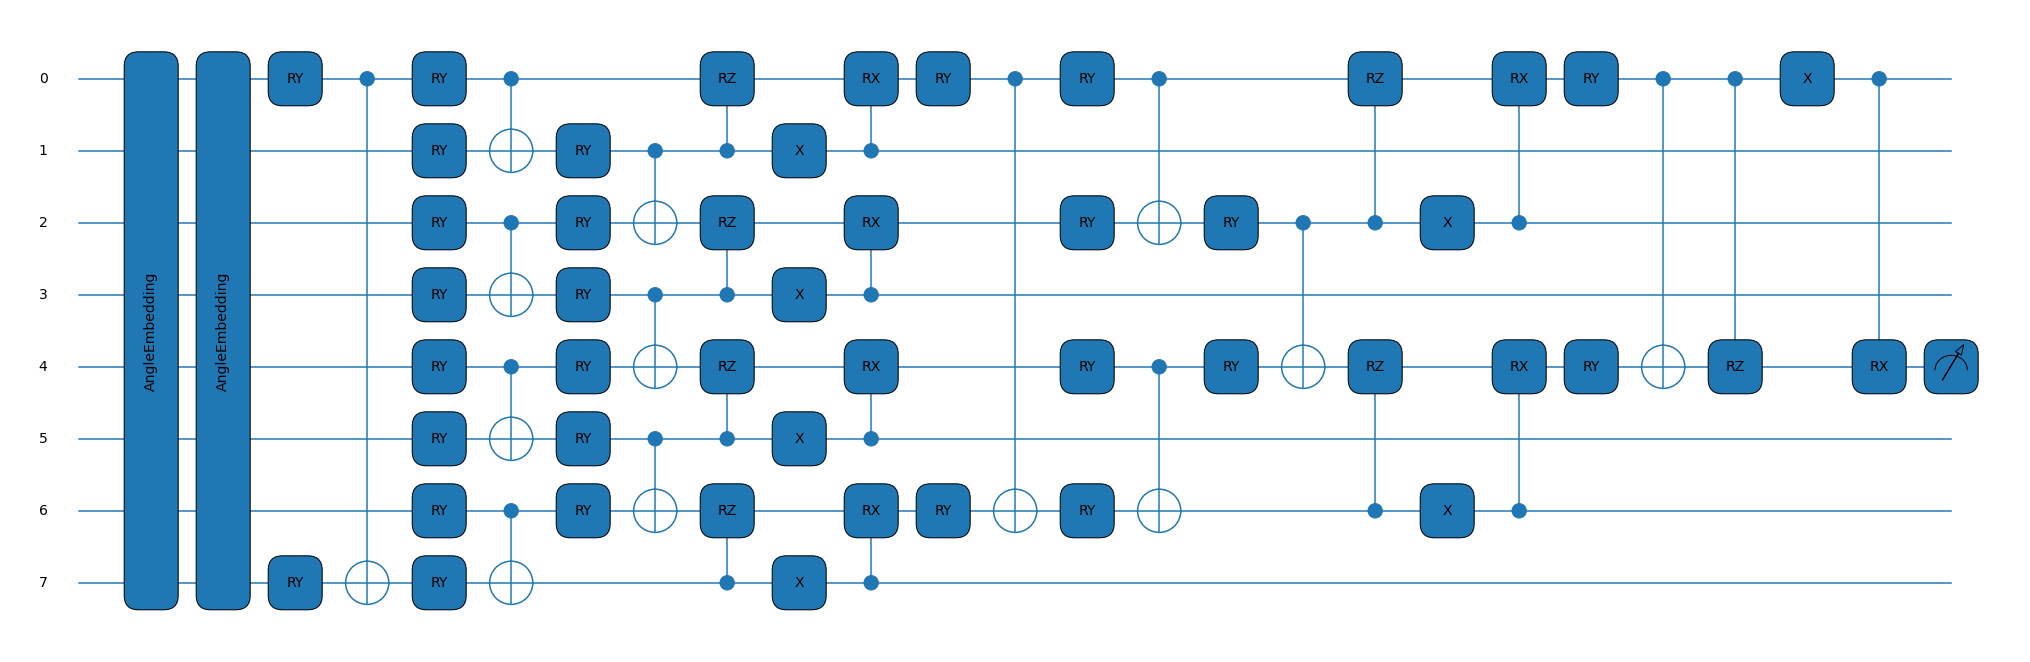

In [ ]:
### channel0의 circuit
random_data1 = np.random.rand(setting.size,3)
fig, ax = qml.draw_mpl(circuit0)(model.params, random_data1)
plt.show()

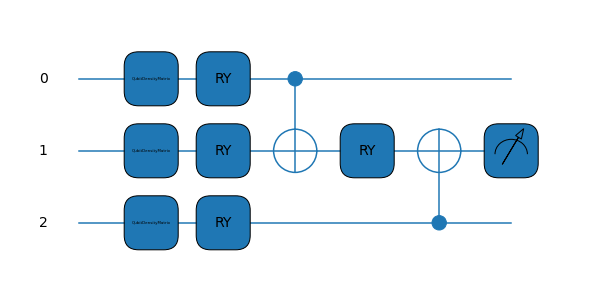

In [ ]:
### final_circuit
random_data2 = np.random.rand(3,2,2)
fig, ax = qml.draw_mpl(final_circuit)(model.params, random_data2)
plt.show()

In [ ]:
init_param = model.params
print( init_param )

[-1.31724123  0.50677748 -0.06381409 -1.30383757 -0.0299005  -0.32282051
  0.33795448  0.08630738 -0.58380145  0.13265701 -0.91469504 -0.76471968
 -1.43783857 -1.31059383 -1.9219675   0.33391881  0.27644755 -0.21396834
 -0.14371567  1.48402032  0.48040241  0.38421985  0.04571504 -0.6430118
 -1.18427552 -0.75820672  0.76304469 -0.17092998 -1.64515723  0.90810978
 -1.21846704  0.67565867  0.03942907 -0.75008847 -1.46426228  0.54720242
  1.94838939  0.17908267  1.39675943  0.18569322]


In [ ]:
############ train model ###########
trainer = Trainer(setting = setting)
trainer.training_model(model, train_X, train_y)


Iteration  10 loss: [1.00022501]
Iteration  20 loss: [0.999339]
Iteration  30 loss: [1.0002949]
Iteration  40 loss: [0.99967521]
Iteration  50 loss: [1.00031622]
Iteration  60 loss: [1.00037849]
Iteration  70 loss: [1.00027008]
Iteration  80 loss: [1.00067537]
Iteration  90 loss: [0.99940556]
Iteration 100 loss: [0.99945744]
Iteration 110 loss: [1.0008627]
Iteration 120 loss: [0.99986639]
Iteration 130 loss: [1.00022839]
Iteration 140 loss: [0.99988888]
Iteration 150 loss: [0.99997899]
Iteration 160 loss: [1.00029822]
Iteration 170 loss: [1.00020388]
Iteration 180 loss: [1.0007713]
Iteration 190 loss: [1.0008813]
Iteration 200 loss: [1.00067234]
Training during 200 iterations finishes (taken time: 0:22:02) 


In [ ]:
after_param = model.params
print( after_param )

[-1.31722554  0.51310492 -0.06998784 -1.30303425 -0.0299005  -0.32282051
  0.33795448  0.08630738 -0.58380145  0.13265701 -0.91469504 -0.76471968
 -1.43783857 -1.31059383 -1.9219675   0.33391881  0.27644755 -0.21396834
 -0.14371567  1.48402032  0.48040241  0.38421985  0.04571504 -0.6430118
 -1.18427552 -0.75820672  0.76304469 -0.17092998 -1.64515723  0.90810978
 -1.21846704  0.67565867  0.03942907 -0.75008847 -1.46426228  0.54720242
  1.94838939  0.17908267  1.39675943  0.18569322]


In [ ]:
############# test model ###############

tester = Tester(setting = setting)
tester.testing_model(model, test_X, test_y)


Test socre: 0.49


In [ ]:
saving_summary(setting, trainer, tester)

TypeError: ignored

In [ ]:
############### loss plot ################

# loss_list
plt.plot(trainer.loss_list)
plot_title = "_".join(setting.filepath.split("/")[-1].split("_")[:-1])
plt.title(f"{plot_title} w/ {str(setting.train_iter)} iteration")
plt.xlabel("ITER")
plt.ylabel("LOSS")
plt.ylim((10, 60))

plt.show()


In [ ]:
plot_title